<a href="https://colab.research.google.com/github/Antara999333/Assignment_7_AIPI/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis

I have used a dataset that contains information related to wine quality and my hypothesis is as follows:

Null Hypothesis (H0): There is no significant difference in the integrated gradients attributions of the neural network model for the features "alcohol content" and "citric acid" in predicting wine quality.

Alternative Hypothesis (H1): There is a significant difference in the integrated gradients attributions of the neural network model for the features "alcohol content" and "citric acid" in predicting wine quality.


In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Assignment_7_AIPI"  # Change to your repo name
git_path = 'https://github.com/Antara999333/Assignment_7_AIPI.git'  # Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'  # Change this if your notebook is in a different folder
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls


Cloning into 'Assignment_7_AIPI'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 2.58 MiB | 5.31 MiB/s, done.
[Errno 2] No such file or directory: 'Assignment_7_AIPI/templates'
/content
Assignment_7_AIPI/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=';')

# Splitting the data
features = data.drop(columns=['quality']).values
labels = data['quality'].values
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2)


scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Converting to tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)


In [ ]:
class WineQualityModel(nn.Module):
    def __init__(self, input_dim):
        super(WineQualityModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 10)  # 10 classes for wine quality ratings 0-9

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

input_dim = train_features.shape[1]
model = WineQualityModel(input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_features, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training
for epoch in range(50):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1, Val Loss: 1.6139, Accuracy: 0.4719
Epoch 2, Val Loss: 1.1279, Accuracy: 0.5375
Epoch 3, Val Loss: 1.0231, Accuracy: 0.5781
Epoch 4, Val Loss: 0.9946, Accuracy: 0.5844
Epoch 5, Val Loss: 0.9769, Accuracy: 0.5750
Epoch 6, Val Loss: 0.9642, Accuracy: 0.5750
Epoch 7, Val Loss: 0.9669, Accuracy: 0.6125
Epoch 8, Val Loss: 0.9582, Accuracy: 0.5906
Epoch 9, Val Loss: 0.9488, Accuracy: 0.5875
Epoch 10, Val Loss: 0.9497, Accuracy: 0.6156
Epoch 11, Val Loss: 0.9466, Accuracy: 0.6219
Epoch 12, Val Loss: 0.9464, Accuracy: 0.6031
Epoch 13, Val Loss: 0.9413, Accuracy: 0.5969
Epoch 14, Val Loss: 0.9413, Accuracy: 0.6219
Epoch 15, Val Loss: 0.9389, Accuracy: 0.6062
Epoch 16, Val Loss: 0.9401, Accuracy: 0.6094
Epoch 17, Val Loss: 0.9428, Accuracy: 0.6094
Epoch 18, Val Loss: 0.9402, Accuracy: 0.6281
Epoch 19, Val Loss: 0.9419, Accuracy: 0.6344
Epoch 20, Val Loss: 0.9355, Accuracy: 0.6344
Epoch 21, Val Loss: 0.9416, Accuracy: 0.6250
Epoch 22, Val Loss: 0.9397, Accuracy: 0.6250
Epoch 23, Val Loss:

In [ ]:

!pip install captum

from captum.attr import IntegratedGradients
import torch

def compute_integrated_gradients(model, inputs, baseline, target):
    ig = IntegratedGradients(model)
    attributions = ig.attribute(inputs, baselines=baseline, target=target)
    return attributions


# Select a sample input and baseline
sample_input = val_features[0:1]
baseline_input = torch.zeros_like(sample_input)

# Compute attributions for "alcohol content" and "citric acid"
alcohol_index = data.columns.get_loc("alcohol")
citric_acid_index = data.columns.get_loc("citric acid")

model.eval()
attributions = compute_integrated_gradients(model, sample_input, baseline_input, target=2)  # Assuming target is class 2

alcohol_attribution = attributions[0, alcohol_index].item()
citric_acid_attribution = attributions[0, citric_acid_index].item()

print(f"Alcohol Attribution: {alcohol_attribution:.4f}")
print(f"Citric Acid Attribution: {citric_acid_attribution:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
Alcohol Attribution: 0.2846
Citric Acid Attribution: -2.0951


T-statistic: 8.1844, P-value: 0.0000


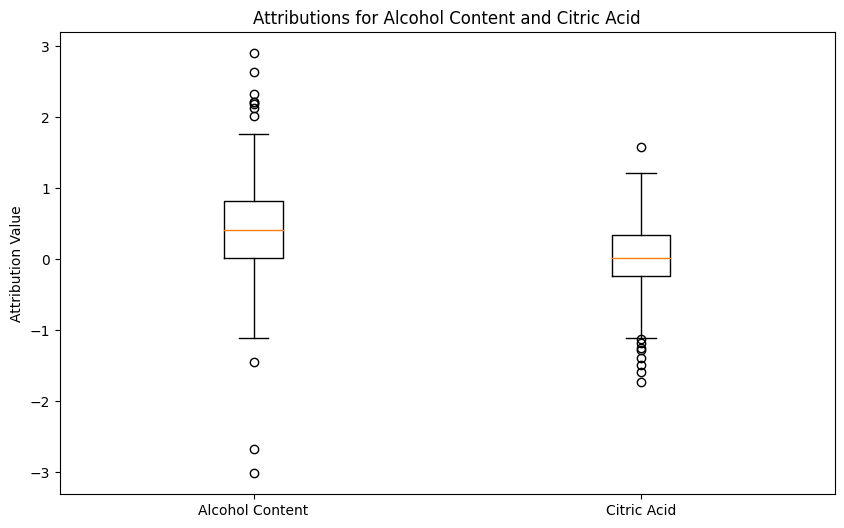

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute attributions for all validation samples
alcohol_attributions = []
citric_acid_attributions = []

for i in range(len(val_features)):
    attributions = compute_integrated_gradients(model, val_features[i:i+1], baseline_input, target=val_labels[i].item())
    alcohol_attributions.append(attributions[0, alcohol_index].item())
    citric_acid_attributions.append(attributions[0, citric_acid_index].item())

# Statistical test
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(alcohol_attributions, citric_acid_attributions)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.boxplot([alcohol_attributions, citric_acid_attributions], labels=['Alcohol Content', 'Citric Acid'])
plt.title('Attributions for Alcohol Content and Citric Acid')
plt.ylabel('Attribution Value')
plt.show()


# Brief Explanation of the approach
I trained a three-layer neural network on the Wine Quality dataset from the UCI Machine Learning Repository. The dataset consists of physicochemical features like alcohol content and citric acid, which are used to predict the quality rating of wine on a scale from 0 to 9. I then prerocessed and standardized the data and I split the dataset into training and validation sets. The training loop optimized the model using cross-entropy loss and the Adam optimizer, achieving a validation accuracy of approximately 60%. I then used the model for Integrated Gradients attribution calculations.

# Visualization
I created a boxplot to visualize the findings. The boxplot shows that the attributions for Alcohol Content and Citric Acid do not overlap. The median for Alcohol Content is significantly higher than the median for Citric Acid and there is a difference in the variability interquartile range of the attributions between the two features. These observations suggest that there is a statistically significant difference in the way these two features contribute to the model's predictions. Further, the relatively larger t statistic and the p value = 0, show that there is definitely a difference in how the variables contribute to the output.

## THE HYPOTHESIS
Based on my results,I must reject the null hypothesis


# SUMMARY OF FINDINGS:
The integrated gradients attributions for "Alcohol Content" and "Citric Acid" differ significantly. This difference suggests that these two features have different impacts on predicting wine quality. Therefore, I reject the null hypothesis , i.e,  there is no significant difference  in the integrated gradients attributions  for the features "alcohol content" and "citric acid" and accept the alternative hypothesis which states that that there is a significant difference.

# Sources
I used the help of generative AI for the boxplot and for helping me build the model